In [18]:
import os,sys

import numpy as np
import xarray as xr
import datetime

import glob

import matplotlib.pyplot as plt

from scipy.special import jv

In [162]:
def OpticsFFT(Ain):
    Aout = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(Ain)))/np.sqrt(np.size(Ain))
    return Aout

def OpticsIFFT(Ain):
    Aout = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(Ain)))*np.sqrt(np.size(Ain))
#     Aout = np.fft.ifftshift(np.fft.ifft2(Ain))*np.sqrt(np.size(Ain))
    return Aout

In [2]:
data_dir = '/glade/p/cisl/aiml/ai4ess_hackathon/holodec/'

In [4]:
file_list = glob.glob(data_dir+'*.nc')
for f_idx,file in enumerate(file_list):
    print(f'{f_idx}.) '+file.split('/')[-1])

0.) synthetic_holograms_7particle_gamma_600x400_training.nc
1.) synthetic_holograms_10particle_gamma_512x512_validation_patches128x128.nc
2.) synthetic_holograms_50-100particle_bidisperse_test.nc
3.) synthetic_holograms_multiparticle_validation.nc
4.) synthetic_holograms_1particle_training_small.nc
5.) synthetic_holograms_6particle_gamma_600x400_test.nc
6.) synthetic_holograms_multiparticle_training.nc
7.) synthetic_holograms_50-100particle_gamma_private.nc
8.) synthetic_holograms_12-25particle_gamma_600x400_validation.nc
9.) synthetic_holograms_6particle_gamma_600x400_training.nc
10.) synthetic_holograms_50-100particle_gamma_training.nc
11.) synthetic_holograms_1particle_gamma_600x400_training.nc
12.) synthetic_holograms_4particle_gamma_600x400_validation.nc
13.) synthetic_holograms_3particle_validation.nc
14.) synthetic_holograms_10particle_gamma_600x400_test.nc
15.) synthetic_holograms_1particle_gamma_600x400_validation.nc
16.) synthetic_holograms_10particle_gamma_600x400_training.n

In [105]:
f_sel = 24
dataFile = file_list[f_sel]

In [106]:
h_ds = xr.open_dataset(dataFile)

In [107]:
h_ds

<xarray.Dataset>
Dimensions:  (hologram_number: 10000, particle: 10000, xsize: 600, ysize: 400)
Dimensions without coordinates: hologram_number, particle, xsize, ysize
Data variables:
    hid      (particle) float32 ...
    d        (particle) float32 ...
    x        (particle) float32 ...
    y        (particle) float32 ...
    z        (particle) float32 ...
    image    (hologram_number, xsize, ysize) uint8 ...
Attributes:
    DateCreated:           27-May-2020
    Nx:                    600.0
    Ny:                    400.0
    dx:                    2.96e-06
    dy:                    2.96e-06
    lambda:                3.55e-07
    Dpmin:                 2e-05
    Dpmax:                 7e-05
    zMin:                  0.014
    zMax:                  0.158
    NParticles:            1.0
    Nbits:                 8.0
    ccdelevel:             20000.0
    gainFactor:            24.0
    readNoiseSTD:          12.0
    gaussCornCon:          1.0
    lowPassFiltCutoff:     2500.0
    fracBeamDistort:       0.02
    should_beam:           1
    should_noise:          1
    should_lnoise:         0
    partRelInt:            0.5
    nHolograms:            10000.0
    makeRandParts:         1
    should_random:         1
    should_extend_domain:  0
    superSamplingRate:     1.0
    should_cache:          1

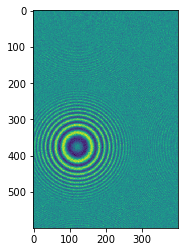

In [110]:
plt.figure()
plt.imshow(h_ds['image'].isel(hologram_number=4))

In [21]:
h_ds['image'].shape

(10000, 600, 400)

In [22]:
dx = 3e-6
dy = 3e-6

In [111]:
Nx = h_ds['image'].shape[1]
x1D = (np.arange(Nx)-np.floor(Nx/2.0))*dx
dfx1D =  1.0/(Nx*np.double(dx))
fx = (np.arange(Nx)-np.floor(Nx/2.0))*dfx1D

Ny = h_ds['image'].shape[2]
y1D = (np.arange(Ny)-np.floor(Ny/2.0))*dy
dfy1D =  1.0/(Ny*np.double(dy))
fy = (np.arange(Ny)-np.floor(Ny/2.0))*dfy1D

In [112]:
lam = 355e-9  # wavelength in m
fx = fx[:,np.newaxis]
fy = fy[np.newaxis,:]
rho = np.sqrt(fx**2+fy**2)

In [144]:
zmax=16e-2

In [145]:
hnum = 4

In [146]:
h_idx = np.where(h_ds['hid']==hnum)
d_arr = h_ds['d'][h_idx].values*1e-6
x_arr = h_ds['x'][h_idx].values*1e-6
y_arr = h_ds['y'][h_idx].values*1e-6
z_arr = h_ds['z'][h_idx].values*1e-6

In [147]:
d = d_arr[0]
x = x_arr[0]
y = y_arr[0]
z = z_arr[0]

In [157]:
ft_part = np.zeros(rho.shape,dtype=complex)
for ai in range(d_arr.size):
    d = d_arr[ai]
    x = x_arr[ai]
    y = y_arr[ai]
    z = zmax-z_arr[ai]
    z_arg = 2*np.pi*z/lam*np.sqrt(1-lam**2*(fx**2+fy**2))
    xy_arg = -2*np.pi*(x*fx+y*fy)/2
    amp_arg = d/(2*rho)*jv(1,np.pi*rho*d)
    amp_arg[rho==0] = d*lam/2

    ft_part += amp_arg*np.exp(1j*z_arg-1j*xy_arg)

/glade/u/home/mhayman/miniconda3/envs/ml-casper/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/glade/u/home/mhayman/miniconda3/envs/ml-casper/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


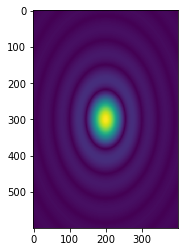

In [158]:
plt.figure()
plt.imshow(np.abs(ft_part))

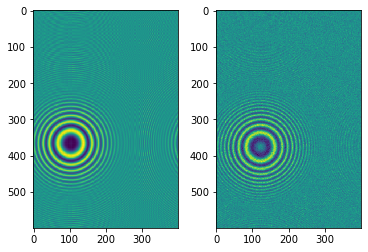

In [172]:
fig,ax_lst = plt.subplots(1,2)
ax_lst[0].imshow(np.abs(np.exp(-1j*np.pi*zmax/lam)+OpticsIFFT(ft_part)[:,::-1])**2)
ax_lst[1].imshow(h_ds['image'].isel(hologram_number=hnum))

In [101]:
d_arr.size

3

In [128]:
z

0.13122456